# Introduction

...Fill...

# Setup

## Imports, config, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib
import model_comparison

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

import warnings
warnings.simplefilter('ignore')


## Load data

Weather and performance data are taken at 1min intervals.  Supplier is the Sandia National Lab Regional Test Center in Albuquerque, NM.  Data spans roughly 2016-April 2017.  This data was scraped from PVDAQ (http://bit.ly/2mKrOwG).  The meteorological data and the performance data are contained in two separate files (technically separate systems - PV system and meteorological station).

SRRL data is available at https://www.nrel.gov/midc/srrl_bms/.  This data is being used because it was already downloaded for a different notebook.  Irradiance data is also measured on a minute-to-minute basis.

In [2]:
def load_snl():
    filename = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
    cols = ['Global_Wm2', 'Date-Time']
    data = pd.read_csv(filename, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])
    data.index = data.index.tz_localize('Etc/GMT+7')
    data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq='1min')).fillna(0)
    data = pd.Series(data['Global_Wm2'], index=data.index)
    data[data < 50] = 0 
    return data

In [3]:
def load_srrl():
    srrl_file = os.path.expanduser('~/data_sets/srrl/20140101.csv')
    srrl_data = pd.read_csv(srrl_file)
    srrl_data.index = pd.to_datetime(srrl_data['DATE (MM/DD/YYYY)'] + ' ' + srrl_data['MST'])
    srrl_data.index = srrl_data.index.tz_localize('Etc/GMT+7')
    srrl_data = srrl_data[~srrl_data.index.duplicated(keep='first')]
    srrl_data.drop(['DATE (MM/DD/YYYY)', 'MST'], inplace=True, axis=1)
    srrl_data = pd.Series(srrl_data['Global 40-South LI-200 [W/m^2]'], index=srrl_data.index)
    srrl_data[srrl_data < 50] = 0
    srrl_data2 = pd.Series(0, index=pd.date_range(start=srrl_data.index.date[0], 
                                                  end=srrl_data.index.date[-1] + pd.Timedelta('1D'), freq='1min'))
    srrl_data2.index = srrl_data2.index.tz_localize('Etc/GMT+7')
    srrl_data2[srrl_data.index] = srrl_data
    srrl_data = srrl_data2.copy()
    return srrl_data

In [4]:
snl_data = load_snl()
srrl_data = load_srrl()

## PVLib

In [5]:
def make_pvlib_sys(tilt, elevation, azimuth, lat, lon):
    sys_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=tilt, surface_azimuth=azimuth)
    sys_loc = pvlib.location.Location(lat, lon, altitude=elevation)
    sys = pvlib.pvsystem.LocalizedPVSystem(pvsystem=sys_no_loc, location=sys_loc)
    return sys

In [6]:
snl_params = {'tilt': 35, 'elevation': 1658, 'azimuth': 180, 
              'lat': 35.0549, 'lon': -106.5433}
rtc = make_pvlib_sys(**snl_params)

In [7]:
srrl_params = {'tilt': 40, 'elevation': 1828.8, 'azimuth': 180, 
               'lat': 39.742, 'lon': -105.18}
srrl = make_pvlib_sys(**srrl_params)

## Analysis functions

In [8]:
def pvlib_compare_plot(sample, mf, pvlib, title=''):
    size = 15
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 5))

    ax = axes[0]
    _ = ax.plot(sample.index, sample)
    _ = ax.scatter(sample.index[mf & ~pvlib], sample[mf & ~pvlib], 
                   facecolor='none', edgecolor='green', label='comparison', s=size)
    _ = ax.scatter(sample.index[pvlib & ~mf], sample[pvlib & ~mf], 
                   facecolor='none', edgecolor='red', label='pvlib', s=size)
    _ = ax.scatter(sample.index[pvlib & mf], sample[pvlib & mf], 
                   facecolor='none', edgecolor='orange', label='both', s=size)
    _ = ax.legend()
    _ = ax.set_ylabel('GHI / W/m^2')
    ax.set_title(title, fontsize='large')
    
    tmp_df = pd.DataFrame()
    tmp_df['comparison'] = mf
    tmp_df['pvlib'] = pvlib
    tmp_df = tmp_df.resample('D').mean()
    tmp_df.index = tmp_df.index.date
    tmp_df.plot(kind='bar', ax=axes[1])
    _ = axes[1].set_ylabel('Pct of day clear')
    
    fig.tight_layout()


# Investigation

## Sandia RTC

In [9]:
sample = snl_data[(snl_data.index >= '2016-07-01') & (snl_data.index < '2016-07-15')]

### Generate model clear sky irradiance and detect clear skies in sample using PVLib functionality.

In [10]:
clear_skies = rtc.get_clearsky(sample.index)
clear_skies = pd.Series(clear_skies['ghi'], index=sample.index)
pvlib_clear, components, alpha = \
    pvlib.clearsky.detect_clearsky(sample, clear_skies, 
                                   sample.index, 10, return_components=True)

### Detect clear skies using reimplementation of RH method

In [11]:
mc = model_comparison.ModelCompareDetect(sample, clear_skies)

In [12]:
compare_clear = mc.reno_hansen_detection()

<IPython.core.display.Javascript object>


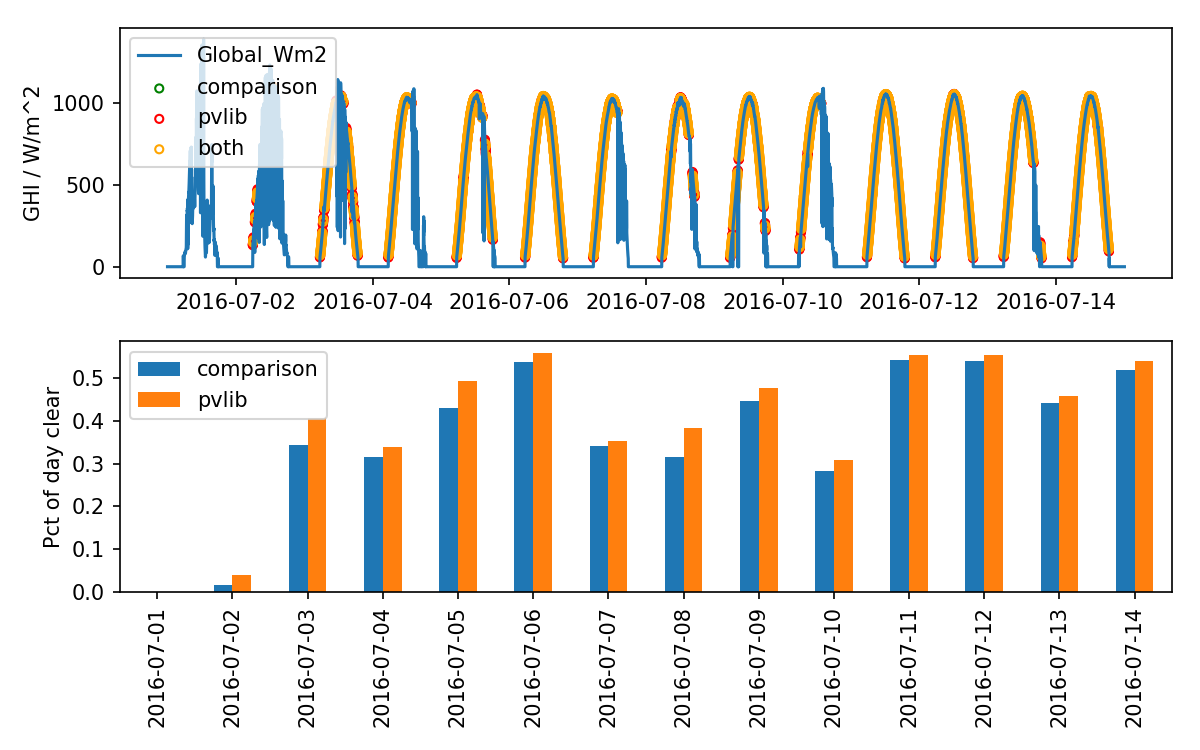

In [13]:
pvlib_compare_plot(sample, compare_clear, pvlib_clear, title='')

The reimplementation of the Reno-Hansen method in PVLib works well.  We notice that the reimplementation ('comparison') labels less points than the PVLib implementation even though the same tolerances are used.  This is expected behavior though.  In the PVLib implementation, all points inside a window that passed all tests was given the 'clear' label.  In this implementation, only the midpoint of clear windows are labeled as clear. 

## Solar Radiation Research Lab BMS

In [14]:
sample = srrl_data[(srrl_data.index >= '2014-01-01') & (srrl_data.index < '2014-01-15')]

### Generate model clear sky irradiance and detect clear skies in sample using PVLib functionality.

In [15]:
clear_skies = rtc.get_clearsky(sample.index)
clear_skies = pd.Series(clear_skies['ghi'], index=sample.index)
pvlib_clear, components, alpha = \
    pvlib.clearsky.detect_clearsky(sample, clear_skies, 
                                   sample.index, 10, return_components=True)

### Detect clear skies using reimplementation of RH method

In [16]:
mc = model_comparison.ModelCompareDetect(sample, clear_skies)

In [17]:
compare_clear = mc.reno_hansen_detection()

<IPython.core.display.Javascript object>


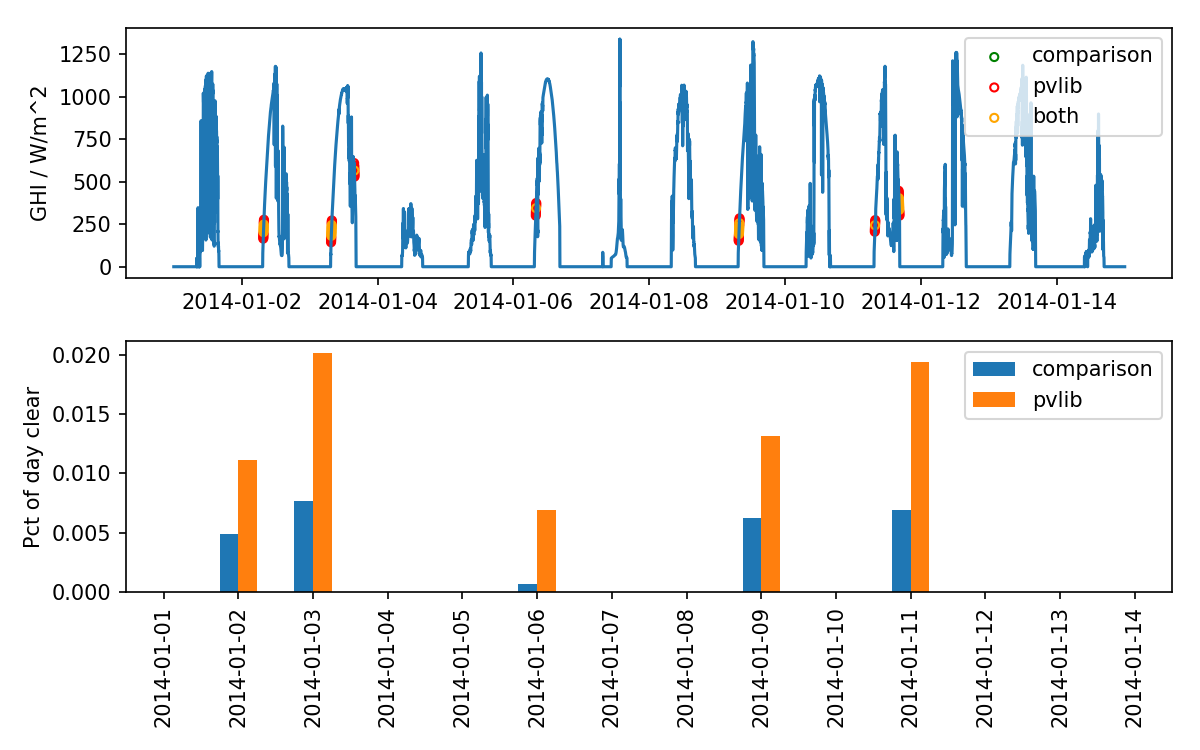

In [18]:
pvlib_compare_plot(sample, compare_clear, pvlib_clear, title='')

Even though it looks bad, this is the desired result.  The reimplementation of RH method and the original method from PVLib behave very similarly, with the reimplementation being more conservative with clear labels.  The reimplemntation will make it easier to analyze correlations in the derived properties and metrics used for classification as well as additional metrics.

# Conclusion






...Fill...